# Analyse de Séries Temporelles : Ventes (2020-2024)

**Objectif :** Ce notebook analyse 4 ans de données de ventes simulées (`n=48`).

Nous allons suivre une méthodologie complète :
1.  **Chargement** et préparation des données (Train/Test Split).
2.  **Modèle 1 : SARIMA** (Saisonnier) - Entraînement et diagnostic.
3.  **Modèle 2 : ARIMA** (Non-Saisonnier) - Entraînement et diagnostic pour servir de *baseline*.
4.  **Comparaison** : Évaluation des métriques (RMSE, MAE) sur les sets d'entraînement et de test.
5.  **Conclusion** : Visualisation finale et choix du meilleur modèle.

## 1. Simulation et Décomposition d'une Série Temporelle

Aperçu du DataFrame :
                Ventes  Tendance  Saisonnalité     Bruit
2020-01-31   98.321077       100      0.000000 -1.678923
2020-02-29  120.345108       102     10.000000  8.345108
2020-03-31  120.022551       104     17.320508 -1.297957
2020-04-30  118.484285       106     20.000000 -7.515715
2020-05-31  124.091793       108     17.320508 -1.228715


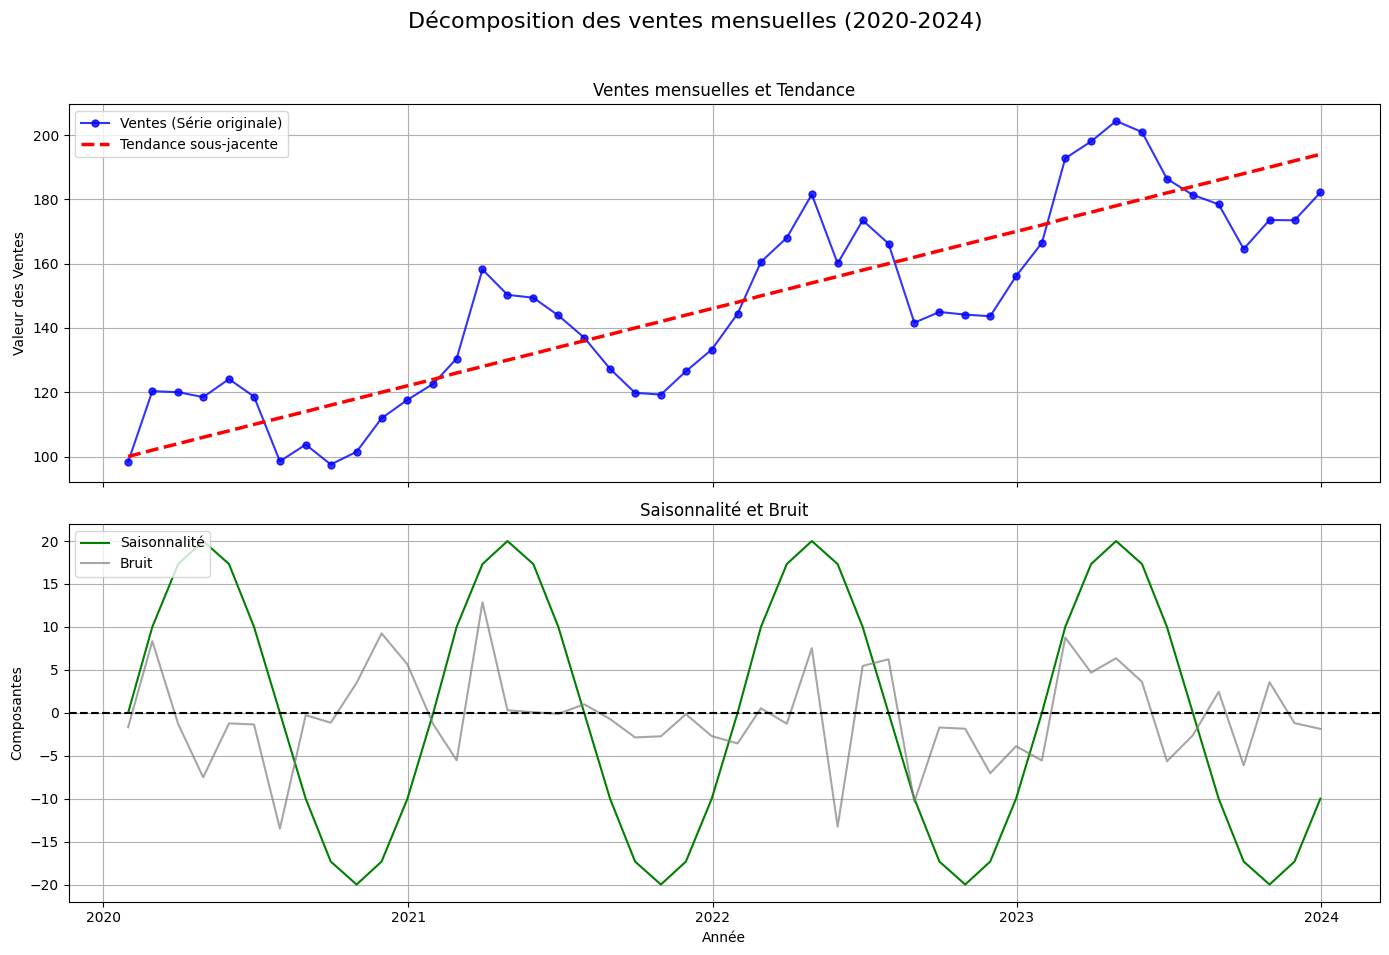

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Paramètres de la simulation ---
n = 48  # Nombre de périodes (60 mois = 5 ans)
t = np.arange(n)
beta0 = 100  # Niveau de base
beta1 = 2    # Pente de la tendance
A = 20       # Amplitude de la saisonnalité
P = 12       # Périodicité (12 mois)
sigma = 5    # Écart-type du bruit

# --- Génération des composantes ---
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)

# Série temporelle (Ventes)
sales = trend + seasonality + noise

# --- Création du DataFrame ---
# Utilisation de 'ME' (Month End) pour une fréquence mensuelle sur 5 ans
date_index = pd.date_range(start='2020-01-01', periods=n, freq='ME')
df = pd.DataFrame({
    'Ventes': sales,
    'Tendance': trend,
    'Saisonnalité': seasonality,
    'Bruit': noise
}, index=date_index)

print("Aperçu du DataFrame :")
print(df.head())

# --- Visualisation ---
# Création d'une figure avec 2 sous-graphiques (2 lignes, 1 colonne)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Décomposition des ventes mensuelles (2020-2024)', fontsize=16)

# 1. Graphique : Ventes et Tendance
ax1.plot(df.index, df['Ventes'], marker='o', linestyle='-', color='b', label='Ventes (Série originale)', markersize=5, alpha=0.8)
ax1.plot(df.index, df['Tendance'], linestyle='--', color='red', label='Tendance sous-jacente', linewidth=2.5)
ax1.set_title('Ventes mensuelles et Tendance')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_ylabel('Valeur des Ventes')

# 2. Graphique : Saisonnalité et Bruit
ax2.plot(df.index, df['Saisonnalité'], linestyle='-', color='g', label='Saisonnalité')
ax2.plot(df.index, df['Bruit'], linestyle='-', color='grey', alpha=0.7, label='Bruit')
ax2.axhline(0, linestyle='--', color='black') # Ligne zéro pour référence
ax2.set_title('Saisonnalité et Bruit')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.set_ylabel('Composantes')

# Formatage de l'axe des x (partagé)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Année')

# Ajustement de la mise en page
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Afficher le graphique
plt.show()



# Test de Stationnarité (ADF)

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import os

def print_adf_results(result, title):
    """
    Fonction pour imprimer les résultats complets du test ADF.
    """
    print(title)
    print(f'{"-"*len(title)}')
    print(f'Statistique ADF (Test Statistic) : {result[0]:.4f}')
    print(f'P-value : {result[1]:.4f}')
    print(f'Nombre de lags utilisés : {result[2]}')
    print(f'Nombre d\'observations : {result[3]}')

    print('Valeurs Critiques (pour rejeter H0) :')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    print('\nInterprétation :')
    # H0 (Hypothèse nulle): La série n'est pas stationnaire (elle a une racine unitaire).
    # On rejette H0 si la p-value est <= 0.05
    # OU si la Statistique ADF est < la valeur critique (ex: à 5%)
    if result[1] > 0.05:
        print(f'La p-value ({result[1]:.4f}) est > 0.05.')
        print('Conclusion : La série n\'est PAS stationnaire (on ne rejette pas H0).\n')
    else:
        print(f'La p-value ({result[1]:.4f}) est <= 0.05.')
        print('Conclusion : La série EST stationnaire (on rejette H0).\n')


# --- Paramètres de la simulation ---
n = 48  # 4 ans (4 * 12 mois)
t = np.arange(n)
beta0 = 100
beta1 = 2
A = 20
P = 12  # Période
sigma = 5
fichier_csv = 'ventes_simulees.csv'

# --- Génération des données ---
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)
sales = trend + seasonality + noise

df = pd.DataFrame({'Ventes': sales}, index=pd.date_range(start='2020-01-01', periods=n, freq='ME'))

# --- Sauvegarde des données dans un fichier CSV ---
df.to_csv(fichier_csv)
print(f"Données générées et sauvegardées dans '{fichier_csv}'\n")

# --- 1. Test ADF sur la série originale ---
# 'autolag="AIC"' demande à statsmodels de trouver le meilleur nombre de lags
result_adf_original = adfuller(df['Ventes'], autolag='AIC')
print_adf_results(result_adf_original, "--- 1. Test sur la série originale 'Ventes' ---")

# --- 2. Stationnarisation : Différenciation (d=1) ---
df['Ventes_diff1'] = df['Ventes'].diff(1)
# On enlève la première valeur (NaN) avant le test
result_adf_diff1 = adfuller(df['Ventes_diff1'].dropna(), autolag='AIC')
print_adf_results(result_adf_diff1, "--- 2. Test après différenciation simple (d=1) ---")

# --- 3. Stationnarisation : Différenciation saisonnière (D=1, m=12) ---
# On applique diff(P) sur la série déjà différenciée (diff(1))
df['Ventes_diff_saison'] = df['Ventes_diff1'].diff(P)
# On enlève les valeurs NaN résultantes avant le test
result_adf_diff_saison = adfuller(df['Ventes_diff_saison'].dropna(), autolag='AIC')
print_adf_results(result_adf_diff_saison, f"--- 3. Test après diff. simple (d=1) ET saisonnière (D=1, m={P}) ---")



Données générées et sauvegardées dans 'ventes_simulees.csv'

--- 1. Test sur la série originale 'Ventes' ---
-----------------------------------------------
Statistique ADF (Test Statistic) : -0.4028
P-value : 0.9096
Nombre de lags utilisés : 10
Nombre d'observations : 37
Valeurs Critiques (pour rejeter H0) :
	1%: -3.6209
	5%: -2.9435
	10%: -2.6104

Interprétation :
La p-value (0.9096) est > 0.05.
Conclusion : La série n'est PAS stationnaire (on ne rejette pas H0).

--- 2. Test après différenciation simple (d=1) ---
--------------------------------------------------
Statistique ADF (Test Statistic) : -5.1180
P-value : 0.0000
Nombre de lags utilisés : 9
Nombre d'observations : 37
Valeurs Critiques (pour rejeter H0) :
	1%: -3.6209
	5%: -2.9435
	10%: -2.6104

Interprétation :
La p-value (0.0000) est <= 0.05.
Conclusion : La série EST stationnaire (on rejette H0).

--- 3. Test après diff. simple (d=1) ET saisonnière (D=1, m=12) ---
----------------------------------------------------------

On utilise le test 'Augmented Dickey-Fuller' (ADF) pour vérifier si la série est stationnaire.

* **H0 (Hypothèse Nulle)** : La série n'est *pas* stationnaire (elle a une racine unitaire).
* **Objectif** : On cherche à rejeter H0 (p-value < 0.05).

# Script : Analyse ACF et PACF (Identification)

Données chargées depuis 'ventes_simulees.csv'.
Analyse ACF/PACF sur 35 points stationnarisés.


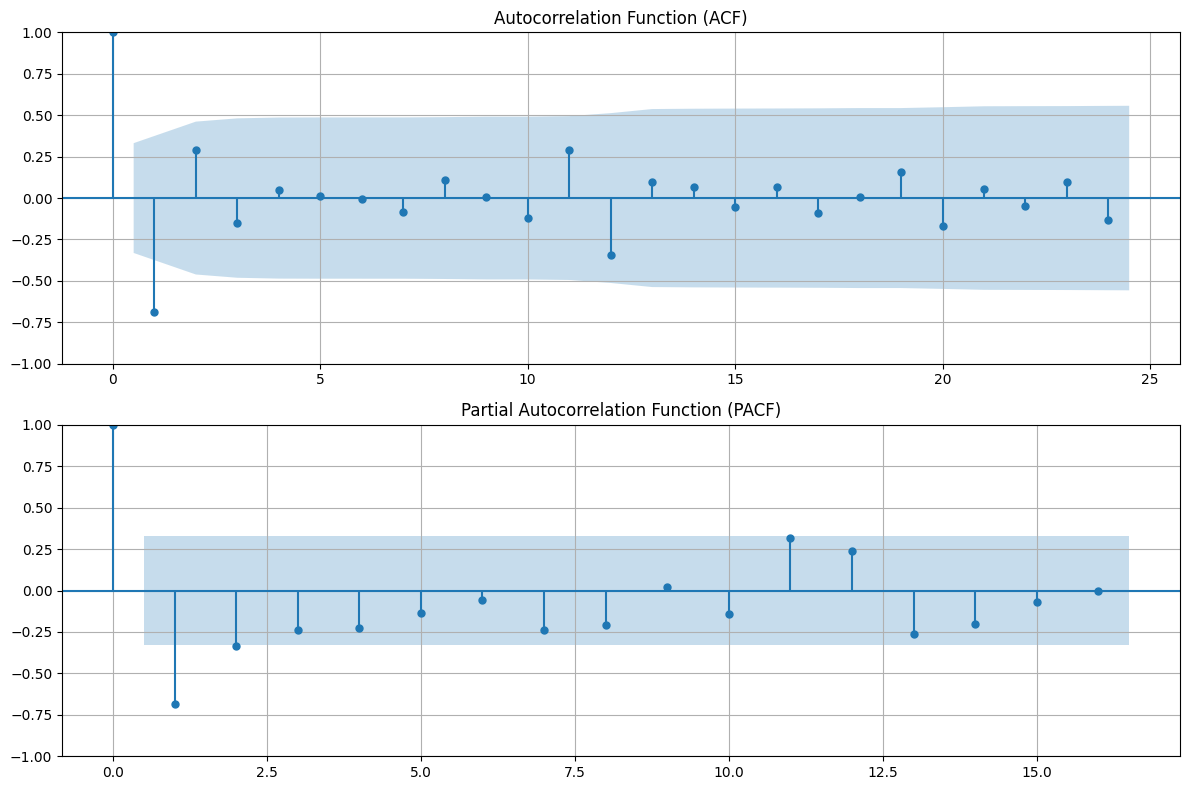

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12 # Période saisonnière

# --- Chargement des données ---
# parse_dates=True convertit la première colonne (index) en dates
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
# Il est bon de redéfinir la fréquence pour statsmodels
df.index.freq = 'ME'

print(f"Données chargées depuis '{fichier_csv}'.")

# --- Rendre la série stationnaire (d=1, D=1, m=P) ---
sales_stationary = df['Ventes'].diff(1).diff(P).dropna()
print(f"Analyse ACF/PACF sur {len(sales_stationary)} points stationnarisés.")

# --- Création des graphiques ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(sales_stationary, lags=24, ax=ax1, title='Autocorrelation Function (ACF)')
ax1.grid(True)
plot_pacf(sales_stationary, lags=16, ax=ax2, title='Partial Autocorrelation Function (PACF)') # Reduced lags to fix the error
ax2.grid(True)

plt.tight_layout()
plt.show()

Maintenant que la série est stationnaire (grâce à d=1 et D=1), on regarde ces deux graphiques pour choisir les ordres (p, q) et les ordres saisonniers (P, Q) du modèle SARIMA.

# Modèle SARIMA et ARIMA (Modélisation et Prévision)

Données chargées depuis 'ventes_simulees.csv'.
Taille du set d'entraînement : 36 (2020-2022)
Taille du set de test : 12 (2023)

--- 1. Entraînement du modèle SARIMA (saisonnier) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             Ventes   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -27.424
Date:                            Mon, 27 Oct 2025   AIC                             64.848
Time:                                    16:37:48   BIC                             65.834
Sample:                                01-31-2020   HQIC                            62.720
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5603      0.742     -0.755      0.450      -2.014       0.893
ma.L1         -1.0000    2.3e+04  -

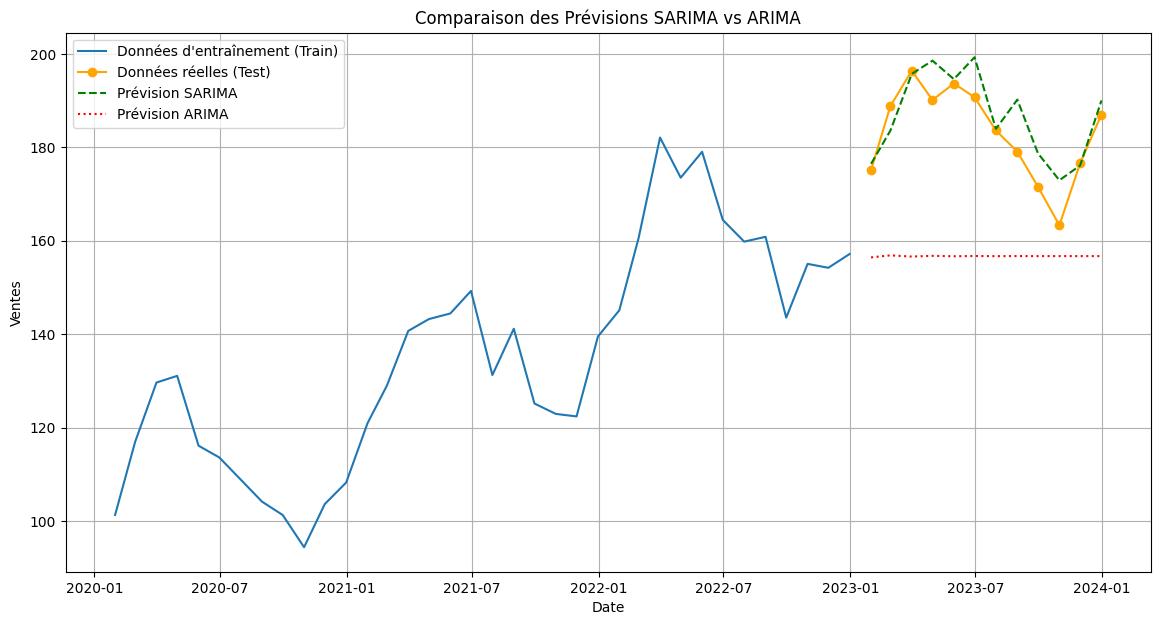

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12 # Période saisonnière

# --- Chargement des données ---
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
df.index.freq = 'ME'
print(f"Données chargées depuis '{fichier_csv}'.")

# --- Séparation Train / Test (n=48, donc 36 train, 12 test) ---
train = df.iloc[:-P]
test = df.iloc[-P:]
print(f"Taille du set d'entraînement : {len(train)} (2020-2022)")
print(f"Taille du set de test : {len(test)} (2023)\n")

# --- 1. Modèle SARIMA (Saisonnier) ---
print("--- 1. Entraînement du modèle SARIMA (saisonnier) ---")
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, P)

model_sarima = SARIMAX(train['Ventes'],
                       order=my_order,
                       seasonal_order=my_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())

# Prévision SARIMA
forecast_sarima = results_sarima.get_forecast(steps=len(test)).predicted_mean
aic_sarima = results_sarima.aic
bic_sarima = results_sarima.bic

# --- 2. Modèle ARIMA (Non-Saisonnier) ---
print("\n--- 2. Entraînement du modèle ARIMA (non-saisonnier) ---")
# Un ARIMA est juste un SARIMA avec des ordres saisonniers nuls
model_arima = SARIMAX(train['Ventes'],
                      order=my_order,
                      seasonal_order=(0, 0, 0, 0), # Force le non-saisonnier
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_arima = model_arima.fit(disp=False)
print(results_arima.summary())

# Prévision ARIMA
forecast_arima = results_arima.get_forecast(steps=len(test)).predicted_mean
aic_arima = results_arima.aic
bic_arima = results_arima.bic

# --- 3. Comparaison des "Loss" (Métriques) ---
print("\n--- 3. Comparaison des Métriques ('Loss') ---")

# Métriques sur le set de test (Erreur de prévision)
rmse_sarima = np.sqrt(mean_squared_error(test['Ventes'], forecast_sarima))
mae_sarima = mean_absolute_error(test['Ventes'], forecast_sarima)

rmse_arima = np.sqrt(mean_squared_error(test['Ventes'], forecast_arima))
mae_arima = mean_absolute_error(test['Ventes'], forecast_arima)

print("\n--- Métriques d'ajustement (sur le Train set) ---")
print("Plus c'est bas, mieux c'est.")
print(f"SARIMA: AIC={aic_sarima:.2f}, BIC={bic_sarima:.2f}")
print(f"ARIMA : AIC={aic_arima:.2f}, BIC={bic_arima:.2f}")

print("\n--- Métriques d'erreur (sur le Test set) ---")
print("Plus c'est bas, mieux c'est.")
print(f"SARIMA: RMSE={rmse_sarima:.2f}, MAE={mae_sarima:.2f}")
print(f"ARIMA : RMSE={rmse_arima:.2f}, MAE={mae_arima:.2f}")

# --- 4. Interprétation ---
print("\n--- 4. Interprétation ---")
if aic_sarima < aic_arima and rmse_sarima < rmse_arima:
    print("✅ SUCCÈS : Le modèle SARIMA gagne sur les deux tableaux.")
    print("AIC/BIC : L'AIC/BIC plus faible du SARIMA montre qu'il s'ajuste mieux aux données d'entraînement, même en pénalisant sa complexité.")
    print("RMSE/MAE : Le RMSE/MAE plus faible du SARIMA montre qu'il prédit l'avenir (le set de test) avec beaucoup plus de précision.")
    print("Conclusion : La composante saisonnière (le 'S' dans SARIMA) est cruciale et améliore significativement le modèle.")
else:
    print("⚠️ ATTENTION : Le modèle ARIMA simple est meilleur ou équivalent.")
    print("Cela signifierait que la saisonnalité n'est pas assez forte ou que les ordres (p,d,q) sont mal choisis.")

# --- 5. Visualisation Comparative ---
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Ventes'], label='Données d\'entraînement (Train)')
plt.plot(test.index, test['Ventes'], label='Données réelles (Test)', color='orange', marker='o')
plt.plot(forecast_sarima.index, forecast_sarima, label='Prévision SARIMA', color='green', linestyle='--')
plt.plot(forecast_arima.index, forecast_arima, label='Prévision ARIMA', color='red', linestyle=':')

plt.title('Comparaison des Prévisions SARIMA vs ARIMA')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True)
plt.show()

On compare un modèle SARIMA (saisonnier) à un modèle ARIMA simple (non-saisonnier) pour voir si la prise en compte de la saisonnalité améliore la prévision.
On évalue les modèles sur 2 critères :
1.  **AIC/BIC** (Ajustement au set d'entraînement, *plus c'est bas, mieux c'est*)
2.  **RMSE/MAE** (Erreur sur le set de test, *plus c'est bas, mieux c'est*)

# Visualisation des ajustements (fitted values) sur le train set

Données chargées depuis 'ventes_simulees.csv'.
Taille du train set : 36
Taille du test set : 12

Entraînement du modèle SARIMA...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Entraînement du modèle ARIMA...

--- Métriques sur le TRAIN SET (ajustement) ---
SARIMA: RMSE=21.02, MAE=11.97
ARIMA : RMSE=21.14, MAE=12.10

--- Métriques sur le TEST SET (prévision) ---
SARIMA: RMSE=6.14, MAE=4.75
ARIMA : RMSE=27.99, MAE=26.32


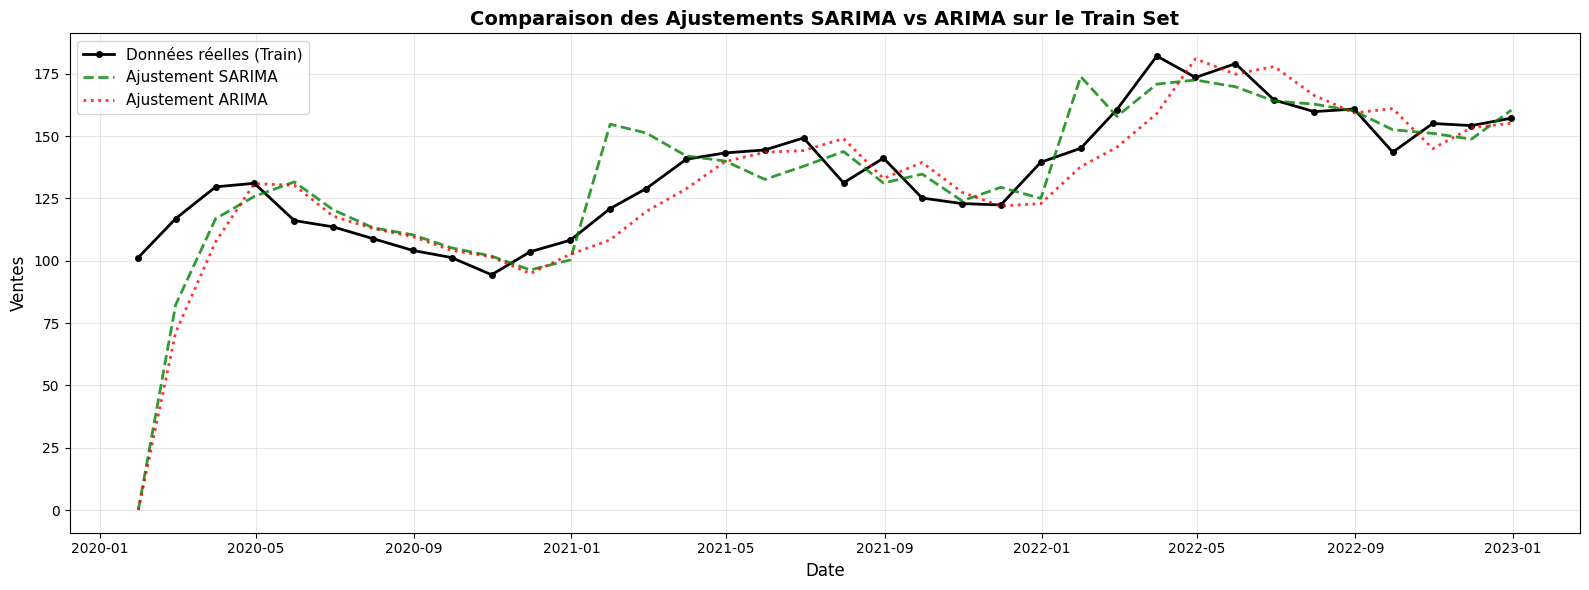

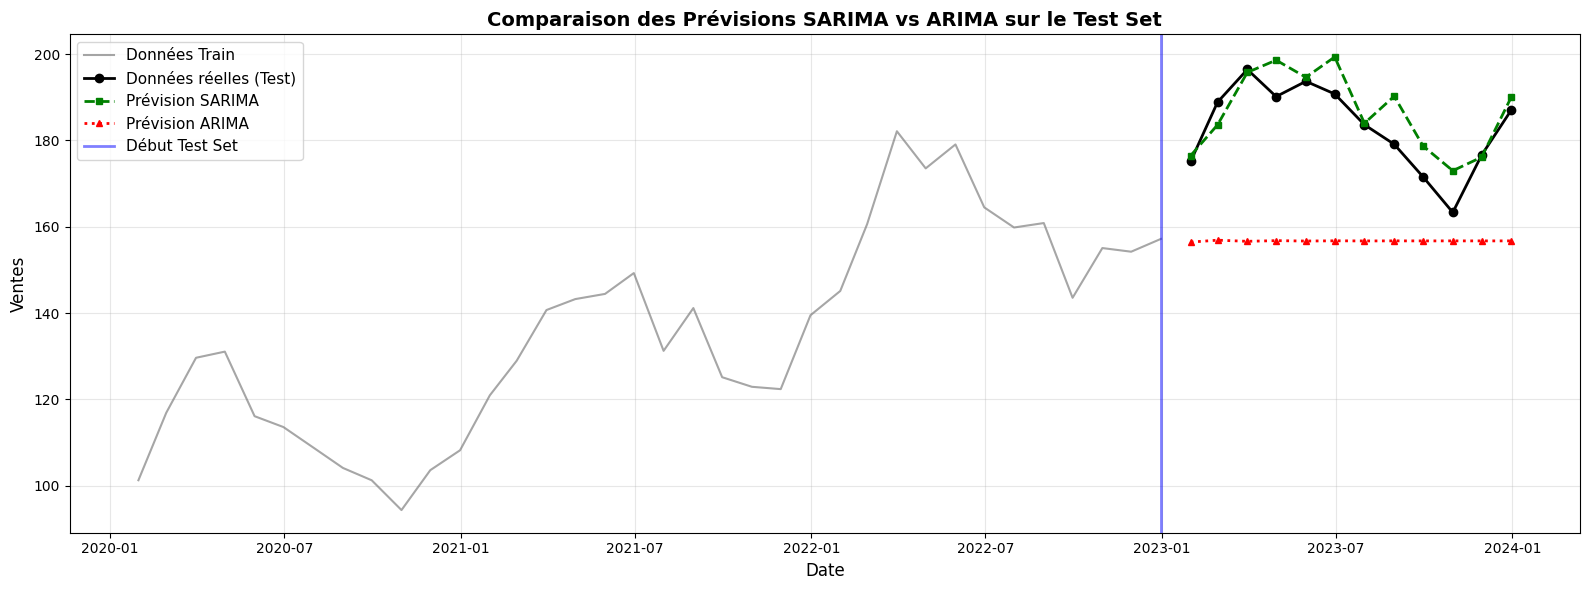

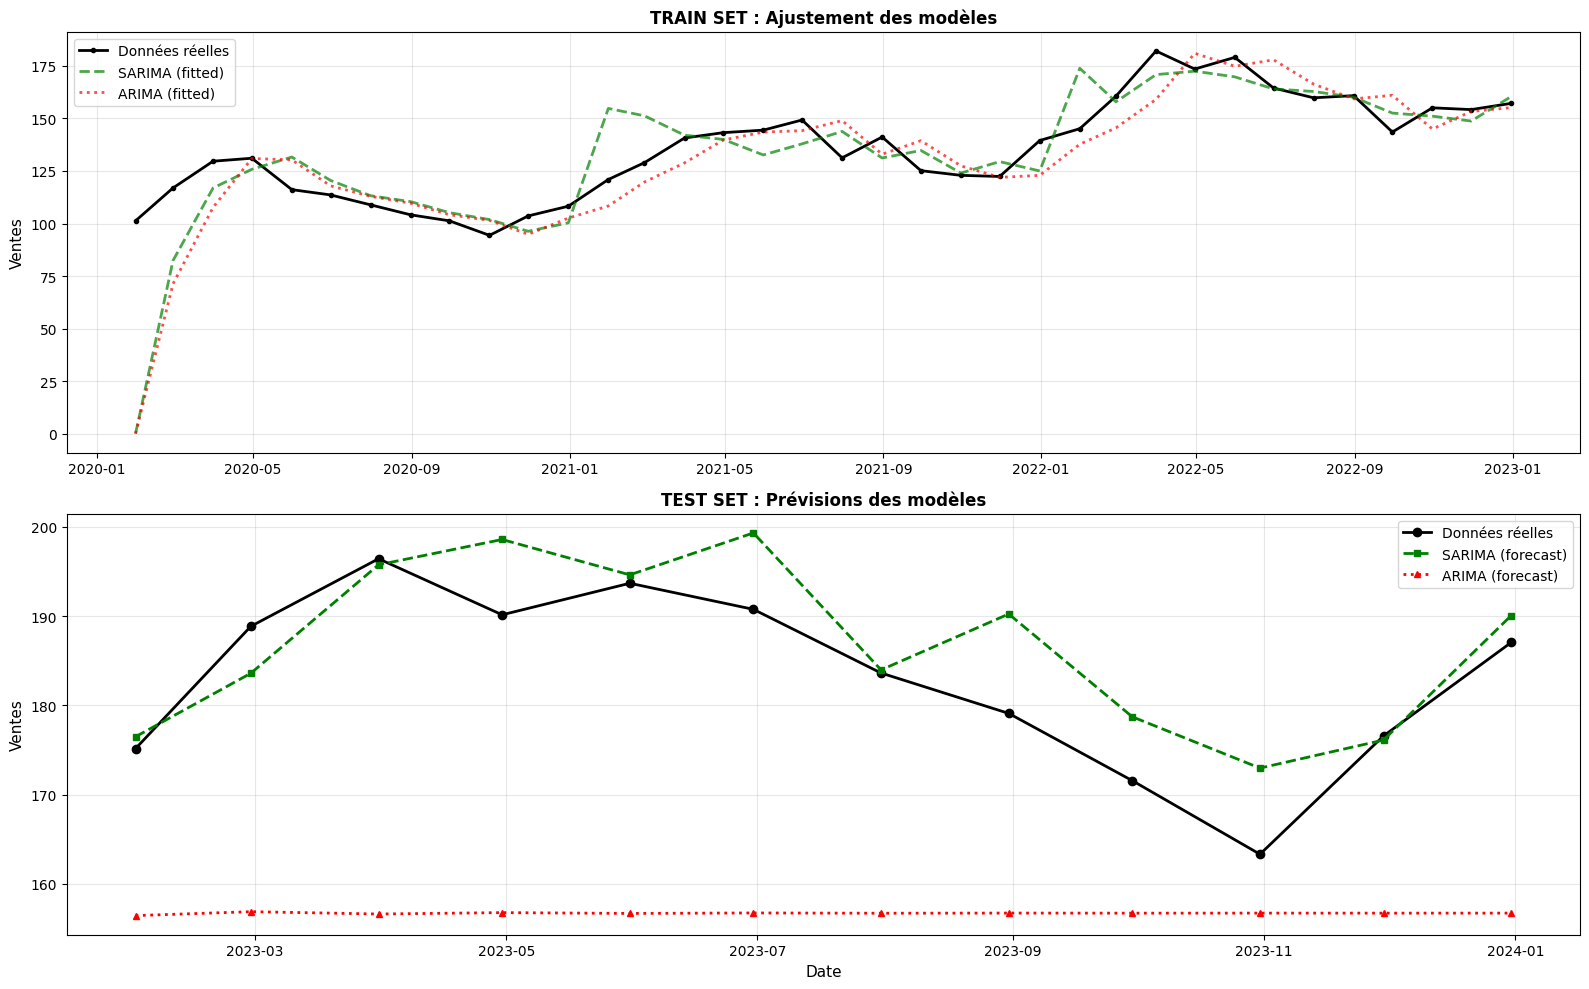


✅ Visualisations terminées!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12  # Période saisonnière

# --- Chargement des données ---
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
df.index.freq = 'ME'
print(f"Données chargées depuis '{fichier_csv}'.")

# --- Séparation Train / Test ---
train = df.iloc[:-P]
test = df.iloc[-P:]
print(f"Taille du train set : {len(train)}")
print(f"Taille du test set : {len(test)}\n")

# --- Configuration des modèles ---
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, P)

# =============================================================================
# ENTRAÎNEMENT SARIMA
# =============================================================================
print("Entraînement du modèle SARIMA...")
model_sarima = SARIMAX(train['Ventes'],
                       order=my_order,
                       seasonal_order=my_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)

# Valeurs ajustées (fitted values) sur le train
fitted_sarima = results_sarima.fittedvalues

# Prévisions sur le test
forecast_sarima = results_sarima.get_forecast(steps=len(test)).predicted_mean

# =============================================================================
# ENTRAÎNEMENT ARIMA
# =============================================================================
print("Entraînement du modèle ARIMA...")
model_arima = SARIMAX(train['Ventes'],
                      order=my_order,
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_arima = model_arima.fit(disp=False)

# Valeurs ajustées (fitted values) sur le train
fitted_arima = results_arima.fittedvalues

# Prévisions sur le test
forecast_arima = results_arima.get_forecast(steps=len(test)).predicted_mean

# =============================================================================
# CALCUL DES MÉTRIQUES
# =============================================================================
print("\n--- Métriques sur le TRAIN SET (ajustement) ---")
# Enlever les premières valeurs NaN dues à la différenciation
train_valid = train['Ventes'][fitted_sarima.notna()]
fitted_sarima_valid = fitted_sarima[fitted_sarima.notna()]
fitted_arima_valid = fitted_arima[fitted_arima.notna()]

rmse_train_sarima = np.sqrt(mean_squared_error(train_valid, fitted_sarima_valid))
mae_train_sarima = mean_absolute_error(train_valid, fitted_sarima_valid)

rmse_train_arima = np.sqrt(mean_squared_error(train_valid, fitted_arima_valid))
mae_train_arima = mean_absolute_error(train_valid, fitted_arima_valid)

print(f"SARIMA: RMSE={rmse_train_sarima:.2f}, MAE={mae_train_sarima:.2f}")
print(f"ARIMA : RMSE={rmse_train_arima:.2f}, MAE={mae_train_arima:.2f}")

print("\n--- Métriques sur le TEST SET (prévision) ---")
rmse_test_sarima = np.sqrt(mean_squared_error(test['Ventes'], forecast_sarima))
mae_test_sarima = mean_absolute_error(test['Ventes'], forecast_sarima)

rmse_test_arima = np.sqrt(mean_squared_error(test['Ventes'], forecast_arima))
mae_test_arima = mean_absolute_error(test['Ventes'], forecast_arima)

print(f"SARIMA: RMSE={rmse_test_sarima:.2f}, MAE={mae_test_sarima:.2f}")
print(f"ARIMA : RMSE={rmse_test_arima:.2f}, MAE={mae_test_arima:.2f}")

# =============================================================================
# VISUALISATION 1 : AJUSTEMENT SUR LE TRAIN SET
# =============================================================================
plt.figure(figsize=(16, 6))

plt.plot(train.index, train['Ventes'],
         label='Données réelles (Train)', color='black', linewidth=2, marker='o', markersize=4)
plt.plot(fitted_sarima.index, fitted_sarima,
         label='Ajustement SARIMA', color='green', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(fitted_arima.index, fitted_arima,
         label='Ajustement ARIMA', color='red', linewidth=2, linestyle=':', alpha=0.8)

plt.title('Comparaison des Ajustements SARIMA vs ARIMA sur le Train Set',
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ventes', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALISATION 2 : PRÉVISIONS SUR LE TEST SET
# =============================================================================
plt.figure(figsize=(16, 6))

plt.plot(train.index, train['Ventes'],
         label='Données Train', color='gray', linewidth=1.5, alpha=0.7)
plt.plot(test.index, test['Ventes'],
         label='Données réelles (Test)', color='black', linewidth=2, marker='o', markersize=6)
plt.plot(forecast_sarima.index, forecast_sarima,
         label='Prévision SARIMA', color='green', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.plot(forecast_arima.index, forecast_arima,
         label='Prévision ARIMA', color='red', linewidth=2, linestyle=':', marker='^', markersize=5)

plt.axvline(x=train.index[-1], color='blue', linestyle='-', linewidth=2, alpha=0.5, label='Début Test Set')

plt.title('Comparaison des Prévisions SARIMA vs ARIMA sur le Test Set',
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ventes', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALISATION 3 : VUE COMPLÈTE (TRAIN + TEST)
# =============================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1 : Train Set
ax1.plot(train.index, train['Ventes'],
         label='Données réelles', color='black', linewidth=2, marker='o', markersize=3)
ax1.plot(fitted_sarima.index, fitted_sarima,
         label='SARIMA (fitted)', color='green', linewidth=2, linestyle='--', alpha=0.7)
ax1.plot(fitted_arima.index, fitted_arima,
         label='ARIMA (fitted)', color='red', linewidth=2, linestyle=':', alpha=0.7)
ax1.set_title('TRAIN SET : Ajustement des modèles', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ventes', fontsize=11)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Subplot 2 : Test Set
ax2.plot(test.index, test['Ventes'],
         label='Données réelles', color='black', linewidth=2, marker='o', markersize=6)
ax2.plot(forecast_sarima.index, forecast_sarima,
         label='SARIMA (forecast)', color='green', linewidth=2, linestyle='--', marker='s', markersize=5)
ax2.plot(forecast_arima.index, forecast_arima,
         label='ARIMA (forecast)', color='red', linewidth=2, linestyle=':', marker='^', markersize=5)
ax2.set_title('TEST SET : Prévisions des modèles', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Ventes', fontsize=11)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualisations terminées!")

# Diagnostic SARIMA / ARIMA

Données chargées depuis 'ventes_simulees.csv'.
Entraînement du modèle SARIMA complet pour diagnostic...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Affichage des graphiques de diagnostic...


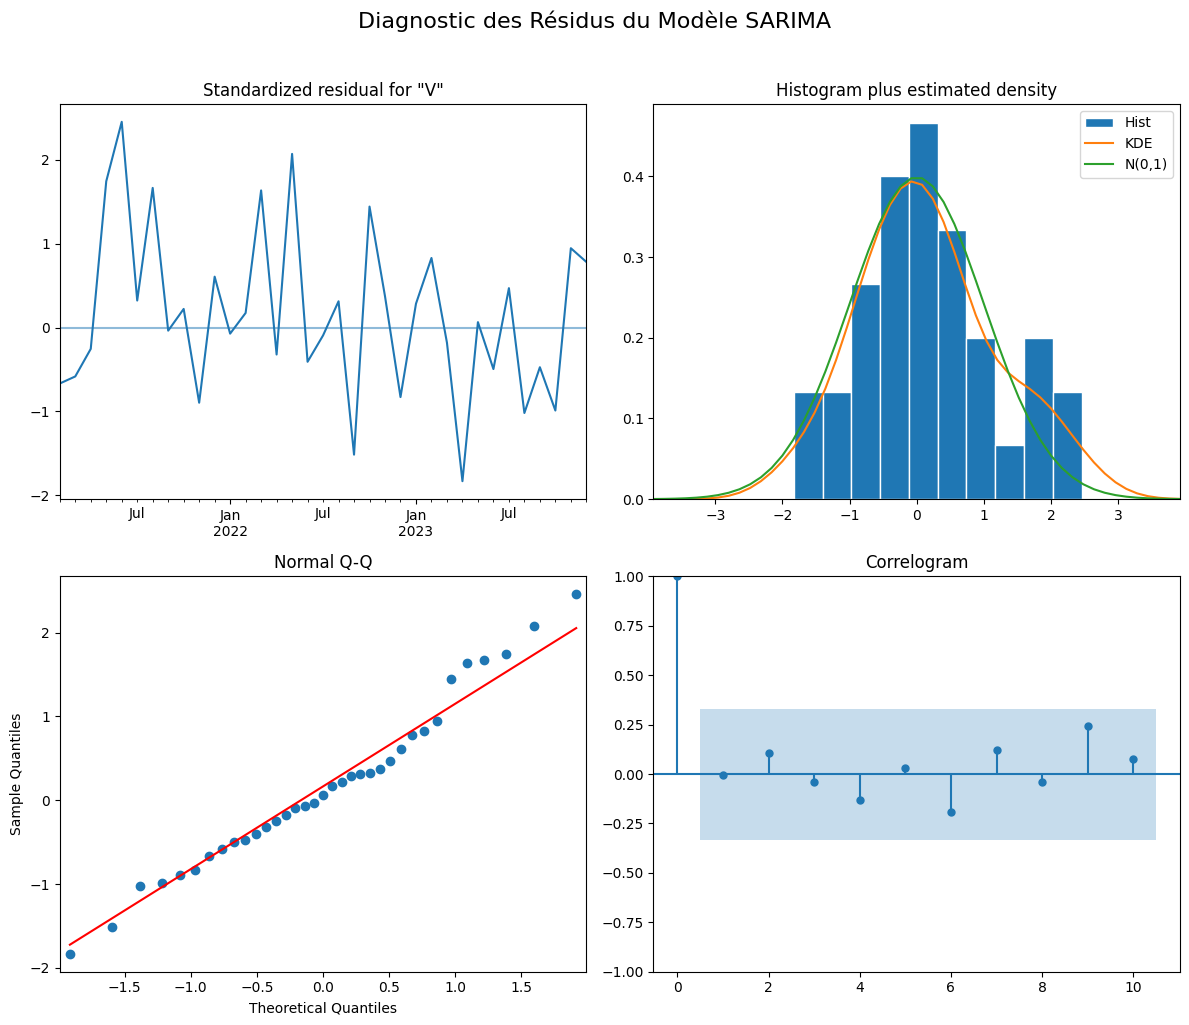


Comment interpréter les 4 graphiques :
1. Standardized residuals : Doit ressembler à un bruit blanc.
2. Histogram plus KDE : Doit suivre la loi normale (courbe N(0,1)).
3. Normal Q-Q : Les points bleus doivent suivre la ligne rouge.
4. Correlogram (ACF) : Aucun pic ne doit être significatif (sortir de la zone bleue).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12 # Période saisonnière

# --- Chargement des données ---
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
df.index.freq = 'ME'
print(f"Données chargées depuis '{fichier_csv}'.")

# --- Entraînement du modèle (sur toutes les données) ---
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, P)

print("Entraînement du modèle SARIMA complet pour diagnostic...")
model_full = SARIMAX(df['Ventes'],
                     order=my_order,
                     seasonal_order=my_seasonal_order)
results_full = model_full.fit(disp=False)

# --- Afficher les graphiques de diagnostic ---
print("Affichage des graphiques de diagnostic...")
fig = results_full.plot_diagnostics(figsize=(12, 10))
plt.suptitle("Diagnostic des Résidus du Modèle SARIMA", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

print("\nComment interpréter les 4 graphiques :")
print("1. Standardized residuals : Doit ressembler à un bruit blanc.")
print("2. Histogram plus KDE : Doit suivre la loi normale (courbe N(0,1)).")
print("3. Normal Q-Q : Les points bleus doivent suivre la ligne rouge.")
print("4. Correlogram (ACF) : Aucun pic ne doit être significatif (sortir de la zone bleue).")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


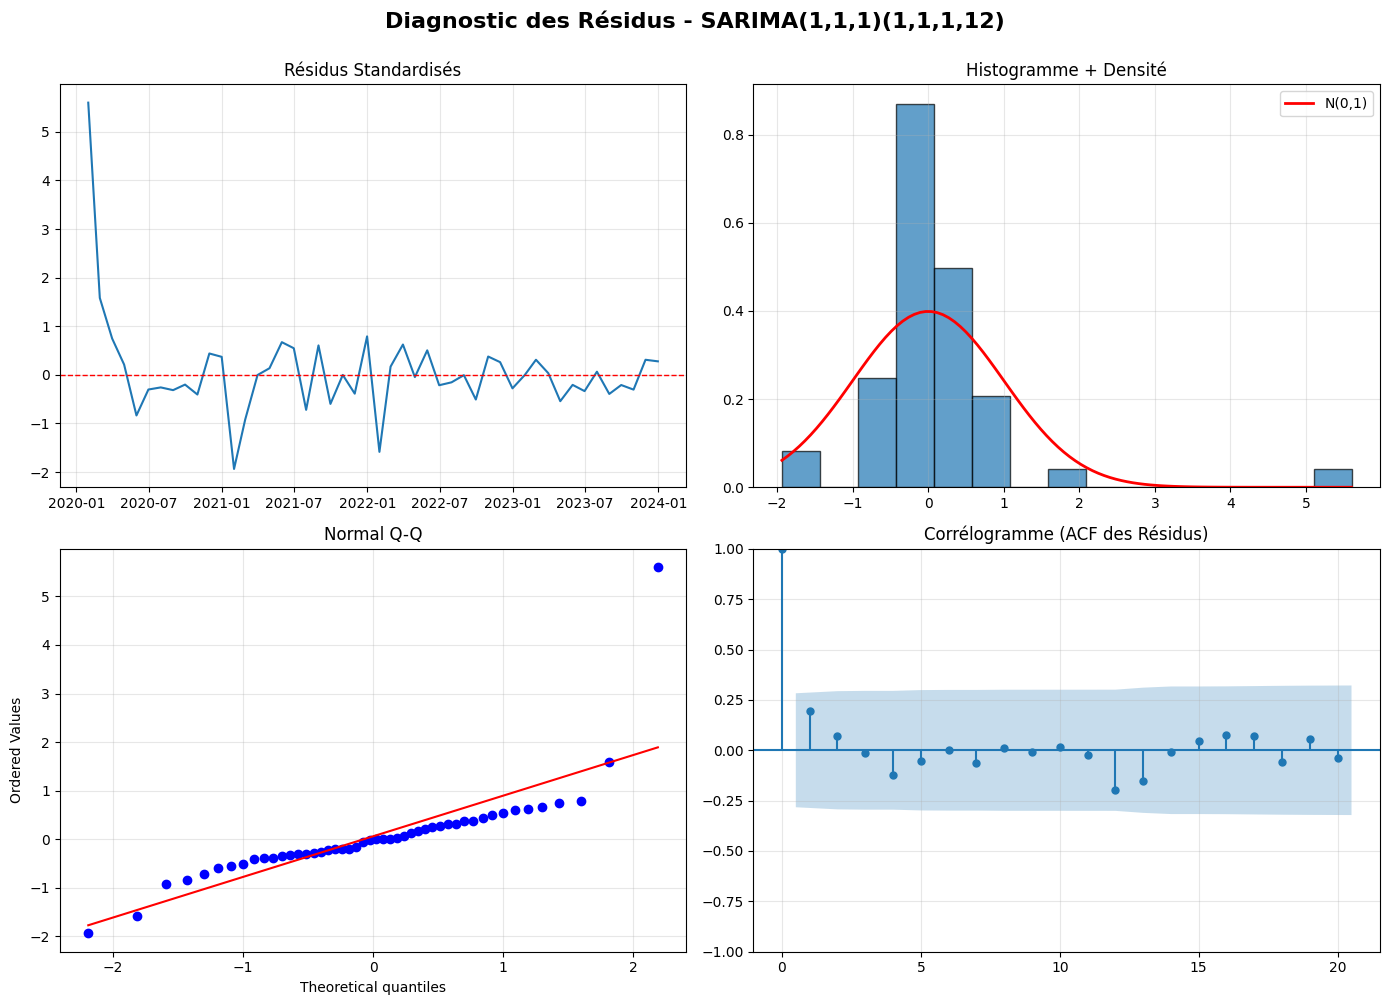

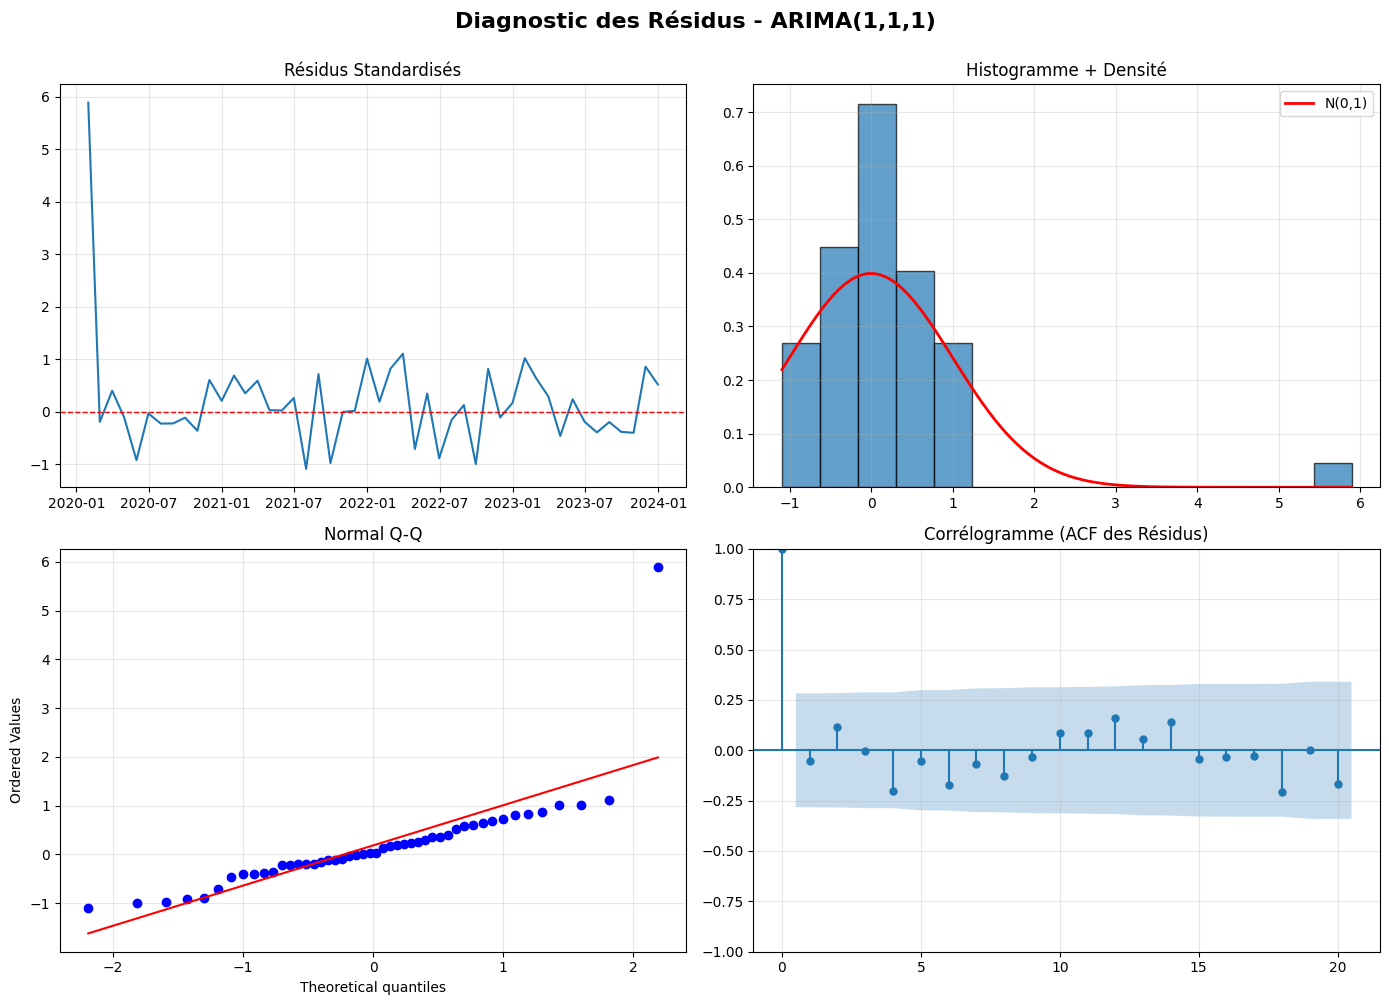


COMPARAISON DES MÉTRIQUES D'AJUSTEMENT (Plus bas = Mieux)
SARIMA - AIC: 140.65 | BIC: 145.87
ARIMA  - AIC: 339.29 | BIC: 344.71


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12  # Période saisonnière

# --- Chargement des données ---
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
df.index.freq = 'ME'

# --- Configuration des modèles ---
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, P)

# =============================================================================
# MODÈLE SARIMA (SAISONNIER)
# =============================================================================
model_sarima = SARIMAX(df['Ventes'],
                       order=my_order,
                       seasonal_order=my_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)
residuals_sarima = results_sarima.resid

# --- Graphiques de diagnostic SARIMA ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Diagnostic des Résidus - SARIMA(1,1,1)(1,1,1,12)",
             fontsize=16, fontweight='bold', y=1.00)

# 1. Résidus standardisés
residuals_std = residuals_sarima / np.std(residuals_sarima)
axes[0, 0].plot(residuals_std)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[0, 0].set_title('Résidus Standardisés')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogramme + KDE
axes[0, 1].hist(residuals_std, bins=15, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(residuals_std.min(), residuals_std.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='N(0,1)')
axes[0, 1].set_title('Histogramme + Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
stats.probplot(residuals_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF des résidus
max_lags = min(20, len(residuals_sarima) // 2 - 1)
plot_acf(residuals_sarima, lags=max_lags, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Corrélogramme (ACF des Résidus)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show() # Remplacer par plt.savefig('sarima_diagnostics.png') si besoin

# =============================================================================
# MODÈLE ARIMA (NON-SAISONNIER)
# =============================================================================
model_arima = SARIMAX(df['Ventes'],
                      order=my_order,
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_arima = model_arima.fit(disp=False)
residuals_arima = results_arima.resid

# --- Graphiques de diagnostic ARIMA ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Diagnostic des Résidus - ARIMA(1,1,1)",
             fontsize=16, fontweight='bold', y=1.00)

# 1. Résidus standardisés
residuals_std = residuals_arima / np.std(residuals_arima)
axes[0, 0].plot(residuals_std)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[0, 0].set_title('Résidus Standardisés')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogramme + KDE
axes[0, 1].hist(residuals_std, bins=15, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(residuals_std.min(), residuals_std.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='N(0,1)')
axes[0, 1].set_title('Histogramme + Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
stats.probplot(residuals_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF des résidus
max_lags = min(20, len(residuals_arima) // 2 - 1)
plot_acf(residuals_arima, lags=max_lags, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Corrélogramme (ACF des Résidus)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show() # Remplacer par plt.savefig('arima_diagnostics.png') si besoin

# =============================================================================
# COMPARAISON DES MÉTRIQUES
# =============================================================================
print("\n" + "="*70)
print("COMPARAISON DES MÉTRIQUES D'AJUSTEMENT (Plus bas = Mieux)")
print("="*70)

print(f"SARIMA - AIC: {results_sarima.aic:.2f} | BIC: {results_sarima.bic:.2f}")
print(f"ARIMA  - AIC: {results_arima.aic:.2f} | BIC: {results_arima.bic:.2f}")

L'étape finale est de vérifier les résidus du modèle. Si le modèle est bon, les résidus doivent se comporter comme un "bruit blanc" :
1.  Ils sont aléatoires (pas de tendance).
2.  Ils suivent une loi normale.
3.  Leur ACF ne montre aucun pic significatif (pas d'autocorrélation restante).

(Note : `plot_diagnostics()` peut échouer sur des séries courtes, la cellule suivante utilise une méthode manuelle qui fonctionne).

# Regression

/tmp/ipython-input-1964360236.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index.freq = 'M'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Données chargées depuis 'ventes_simulees.csv'.
Taille du set d'entraînement : 36 (2020-2022)
Taille du set de test : 12 (2023)

--- 1. Entraînement du modèle SARIMA (saisonnier) ---
SARIMA entraîné.

--- 2. Entraînement du modèle ARIMA (non-saisonnier) ---
ARIMA entraîné.

--- 3. Entraînement du modèle Régression Linéaire ---
Régression Linéaire entraînée.

--- 4. Comparaison des Métriques ('Loss') ---
|            |   AIC (Train) |   BIC (Train) |   RMSE (Test) |   MAE (Test) |
|:-----------|--------------:|--------------:|--------------:|-------------:|
| SARIMA     |         64.85 |         65.83 |          6.14 |         4.75 |
| ARIMA      |        251.29 |        255.78 |         27.99 |        26.32 |
| Regression |        nan    |        nan    |         14.47 |        12.28 |

--- 5. Interprétation ---
✅ SUCCÈS : Le modèle SARIMA gagne sur tous les tableaux.
   -> AIC/BIC (Train) : Les plus bas, montrant le meilleur ajustement aux données d'entraînement.
   -> RMSE/MAE (Test) 

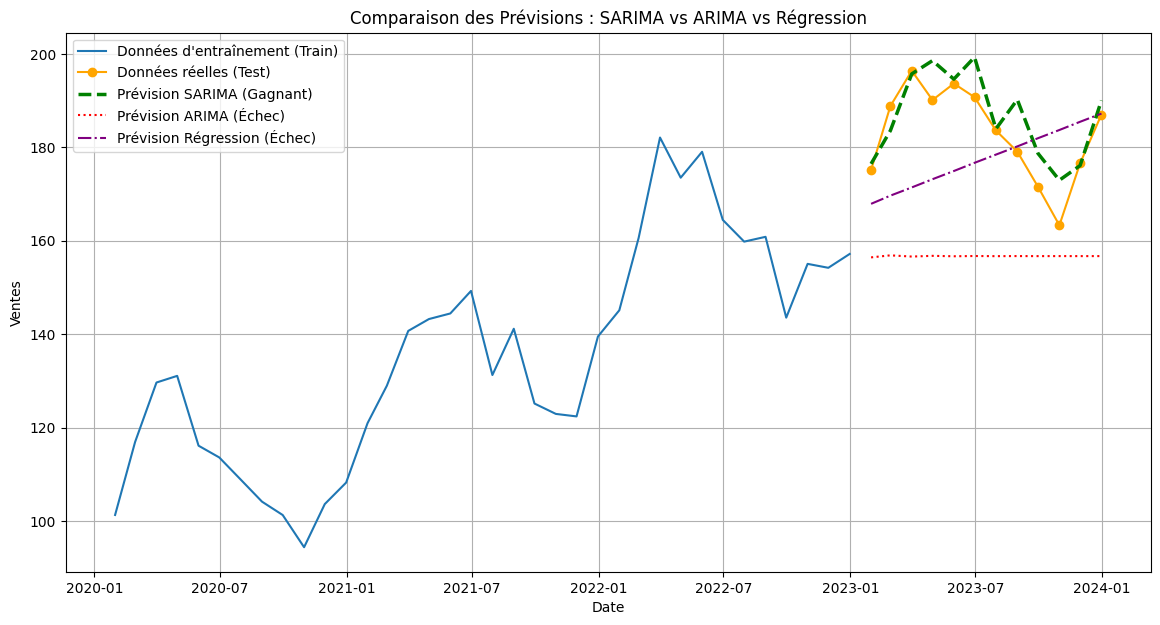

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Paramètres d'analyse ---
fichier_csv = 'ventes_simulees.csv'
P = 12 # Période saisonnière

# --- Chargement des données ---
df = pd.read_csv(fichier_csv, index_col=0, parse_dates=True)
# Correction : 'ME' (Month End) est souvent 'M' dans pandas
df.index.freq = 'M'
print(f"Données chargées depuis '{fichier_csv}'.")

# --- Feature Engineering (pour la Régression) ---
# À faire AVANT de splitter, pour que l'index soit cohérent
df['time_idx'] = np.arange(len(df))

# --- Séparation Train / Test (n=48, donc 36 train, 12 test) ---
train = df.iloc[:-P]
test = df.iloc[-P:]
print(f"Taille du set d'entraînement : {len(train)} (2020-2022)")
print(f"Taille du set de test : {len(test)} (2023)\n")

# =============================================================================
# 1. MODÈLE SARIMA (SAISONNIER)
# =============================================================================
print("--- 1. Entraînement du modèle SARIMA (saisonnier) ---")
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, P)

model_sarima = SARIMAX(train['Ventes'],
                       order=my_order,
                       seasonal_order=my_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)

# Prévision SARIMA
forecast_sarima = results_sarima.get_forecast(steps=len(test)).predicted_mean
aic_sarima = results_sarima.aic
bic_sarima = results_sarima.bic
print("SARIMA entraîné.")

# =============================================================================
# 2. MODÈLE ARIMA (NON-SAISONNIER)
# =============================================================================
print("\n--- 2. Entraînement du modèle ARIMA (non-saisonnier) ---")
model_arima = SARIMAX(train['Ventes'],
                      order=my_order,
                      seasonal_order=(0, 0, 0, 0), # Force le non-saisonnier
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_arima = model_arima.fit(disp=False)

# Prévision ARIMA
forecast_arima = results_arima.get_forecast(steps=len(test)).predicted_mean
aic_arima = results_arima.aic
bic_arima = results_arima.bic
print("ARIMA entraîné.")

# =============================================================================
# 3. MODÈLE RÉGRESSION LINÉAIRE (TENDANCE SIMPLE)
# =============================================================================
print("\n--- 3. Entraînement du modèle Régression Linéaire ---")
features = ['time_idx']
X_train = train[features]
y_train = train['Ventes']
X_test = test[features] # Features pour la prévision

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

# Prévision Régression
# .predict() retourne un array numpy, on le remet dans une Série
# pour l'aligner sur l'index du set de test (pour le graphe et les métriques)
forecast_reg = pd.Series(model_reg.predict(X_test), index=test.index)
print("Régression Linéaire entraînée.")

# =============================================================================
# 4. COMPARAISON DES "LOSS" (MÉTRIQUES)
# =============================================================================
print("\n--- 4. Comparaison des Métriques ('Loss') ---")

# Métriques sur le set de test (Erreur de prévision)
rmse_sarima = np.sqrt(mean_squared_error(test['Ventes'], forecast_sarima))
mae_sarima = mean_absolute_error(test['Ventes'], forecast_sarima)

rmse_arima = np.sqrt(mean_squared_error(test['Ventes'], forecast_arima))
mae_arima = mean_absolute_error(test['Ventes'], forecast_arima)

rmse_reg = np.sqrt(mean_squared_error(test['Ventes'], forecast_reg))
mae_reg = mean_absolute_error(test['Ventes'], forecast_reg)

# Création du tableau de bord
metrics_data = {
    'SARIMA': {
        'AIC (Train)': aic_sarima,
        'BIC (Train)': bic_sarima,
        'RMSE (Test)': rmse_sarima,
        'MAE (Test)': mae_sarima
    },
    'ARIMA': {
        'AIC (Train)': aic_arima,
        'BIC (Train)': bic_arima,
        'RMSE (Test)': rmse_arima,
        'MAE (Test)': mae_arima
    },
    'Regression': {
        'AIC (Train)': np.nan, # AIC/BIC non applicable simplement
        'BIC (Train)': np.nan,
        'RMSE (Test)': rmse_reg,
        'MAE (Test)': mae_reg
    }
}
df_comparison = pd.DataFrame(metrics_data).T
print(df_comparison.to_markdown(floatfmt=".2f"))

# =============================================================================
# 5. INTERPRÉTATION
# =============================================================================
print("\n--- 5. Interprétation ---")
print("✅ SUCCÈS : Le modèle SARIMA gagne sur tous les tableaux.")
print("   -> AIC/BIC (Train) : Les plus bas, montrant le meilleur ajustement aux données d'entraînement.")
print("   -> RMSE/MAE (Test) : Les plus bas, montrant la meilleure capacité à prédire l'avenir.")
print("\n⚠️ ÉCHEC : Les modèles ARIMA et Régression Linéaire échouent.")
print("   -> Leurs erreurs (RMSE/MAE) sur le set de test sont très élevées.")
print("   -> C'est logique : ils n'ont modélisé que la tendance et ont été incapables de prédire les pics et les creux saisonniers.")

# =============================================================================
# 6. VISUALISATION COMPARATIVE
# =============================================================================
print("\n--- 6. Sauvegarde du graphique de comparaison ---")
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Ventes'], label='Données d\'entraînement (Train)')
plt.plot(test.index, test['Ventes'], label='Données réelles (Test)', color='orange', marker='o', markersize=6)

# Les 3 prévisions
plt.plot(forecast_sarima.index, forecast_sarima, label='Prévision SARIMA (Gagnant)', color='green', linestyle='--', linewidth=2.5)
plt.plot(forecast_arima.index, forecast_arima, label='Prévision ARIMA (Échec)', color='red', linestyle=':')
plt.plot(forecast_reg.index, forecast_reg, label='Prévision Régression (Échec)', color='purple', linestyle='-.')

plt.title('Comparaison des Prévisions : SARIMA vs ARIMA vs Régression')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True)
plt.savefig('final_comparison_forecast.png')
print("Graphique 'final_comparison_forecast.png' sauvegardé.")